# Estimating performance

In this notebook, we show how to obtain estimates for LLM performance by combining anchor points and IRT.

## Preparing data

Loading packages

In [2]:
import numpy as np
import pickle
from tqdm import tqdm
from irt import *
from utils import *

random_state = 42

The leaderboard dataset we will use is composed by six scenarios (sub-datasets):
1. TruthfulQA
1. GSM8K
1. Winogrande
1. ARC
1. HellaSwag
1. MMLU

MMLU is further divided into sub-scenarios (e.g., abstract algebra, anatomy, etc). Let's check scenarios and sub-scenarios:

In [3]:
scenarios

{'harness_truthfulqa_mc_0': ['harness_truthfulqa_mc_0'],
 'gsm8k': ['harness_gsm8k_5'],
 'winogrande': ['harness_winogrande_5'],
 'arc': ['harness_arc_challenge_25'],
 'hellaswag': ['harness_hellaswag_10'],
 'mmlu': ['harness_hendrycksTest_abstract_algebra_5',
  'harness_hendrycksTest_anatomy_5',
  'harness_hendrycksTest_astronomy_5',
  'harness_hendrycksTest_business_ethics_5',
  'harness_hendrycksTest_clinical_knowledge_5',
  'harness_hendrycksTest_college_biology_5',
  'harness_hendrycksTest_college_chemistry_5',
  'harness_hendrycksTest_college_computer_science_5',
  'harness_hendrycksTest_college_mathematics_5',
  'harness_hendrycksTest_college_medicine_5',
  'harness_hendrycksTest_college_physics_5',
  'harness_hendrycksTest_computer_security_5',
  'harness_hendrycksTest_conceptual_physics_5',
  'harness_hendrycksTest_econometrics_5',
  'harness_hendrycksTest_electrical_engineering_5',
  'harness_hendrycksTest_elementary_mathematics_5',
  'harness_hendrycksTest_formal_logic_5',
 

Loading leaderboard data:

In [4]:
with open('data/lb.pickle', 'rb') as handle:
    data = pickle.load(handle)

In this dataset, we have data from 395 models. Let's see the names of some of them below

In [7]:
len(data['models']), data['models'][:10]

(395,
 ['open-llm-leaderboard/details_zhengr__MixTAO-7Bx2-MoE-DPO',
  'open-llm-leaderboard/details_alignment-handbook__zephyr-7b-sft-full',
  'open-llm-leaderboard/details_rombodawg__Leaderboard-killer-MoE_4x7b',
  'open-llm-leaderboard/details_FelixChao__ExtremeDolphin-MoE',
  'open-llm-leaderboard/details_LoSboccacc__orthogonal-2x7B-base',
  'open-llm-leaderboard/details_moreh__MoMo-70B-lora-1.8.6-DPO',
  'open-llm-leaderboard/details_deepseek-ai__deepseek-moe-16b-base',
  'open-llm-leaderboard/details_Swisslex__Mixtral-Orca-v0.1',
  'open-llm-leaderboard/details_wang7776__Mistral-7B-Instruct-v0.2-sparsity-20',
  'open-llm-leaderboard/details_nfaheem__Marcoroni-7b-DPO-Merge'])

In [10]:
data["data"]

{'harness_hendrycksTest_abstract_algebra_5': {'correctness': array([[0., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 0., 0.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [0., 1., 1., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 0., 1.],
         [0., 0., 1., ..., 0., 1., 0.]])},
 'harness_hendrycksTest_anatomy_5': {'correctness': array([[0., 0., 0., ..., 1., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 1., 1., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 1., 1., 1.]])},
 'harness_hendrycksTest_astronomy_5': {'correctness': array([[0., 1., 0., ..., 0., 1., 0.],
         [1., 1., 1., ..., 1., 1., 1.],
         [0., 1., 0., ..., 1., 0., 0.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 0., 0.]])},
 'harness_hendrycksTest_business_ethics_5': {'correctness': array([[

The `data` file does not have the prompts nor the raw responses from the LLMs. I don't even know if those are available for the Open Leaderboard.

Below, we will process the data so all correctness scores (for all scenarios) are stored in $Y$. The dictionaries `scenarios_position` and `subscenarios_position` give the position of scenarios/subscenarios correctness scores in $Y$.

In [11]:
scenarios_position, subscenarios_position = prepare_data(scenarios, data)
Y = create_responses(scenarios, data)
Y.shape

(395, 28659)

395 models, 28k+ instances (pooled across datasets)

For example, below you can see the scores for MMLU:

In [6]:
Y[:, scenarios_position['mmlu']], Y[:, scenarios_position['mmlu']].shape

(array([[0., 0., 1., ..., 1., 1., 0.],
        [0., 0., 1., ..., 1., 1., 0.],
        [0., 0., 1., ..., 1., 1., 0.],
        ...,
        [0., 0., 1., ..., 1., 1., 0.],
        [0., 0., 1., ..., 1., 1., 0.],
        [1., 0., 1., ..., 1., 1., 0.]]),
 (395, 14042))

For scenarios that have multiple subscenarios, it is usually the case that we want to give equal importance to individual subscenarios when computing the aggregated performance in that scenario. This is equivalent to using a weighted average when computing the aggregated performance. We will create balance_weights, a vector of weights to help us compute those weighted averages. These weights will be different than one only for MMLU, which is the only scenario with multiple subscenarios.

We will use this when choosing the IRT dimension.

In [13]:
balance_weights = np.ones(Y.shape[1])

N = len(scenarios_position['mmlu'])
n_sub = len(scenarios['mmlu'])
for sub in scenarios['mmlu']:
    n_i = len(subscenarios_position['mmlu'][sub])
    balance_weights[subscenarios_position['mmlu'][sub]] = N / (n_sub * n_i)

We can see below that first averaging within subscenarios and then computing a simple average is equivalent to using a weighted average from the beginning:

In [8]:
accs1 = np.mean([Y[:, subscenarios_position['mmlu'][sub]].mean(axis=1) for sub in scenarios['mmlu']], axis=0)
accs2 = (balance_weights * Y)[:, scenarios_position['mmlu']].mean(axis=1)

np.abs(accs1 - accs2).mean()

2.322333605307685e-14

## Obtaining estimates

Let's split the data in train and test (recent models are placed in the test set). We will not used the training par in this notebook, since they were already used in `anchor_points.ipynb` and `training_irt.ipynb` to obtain anchor points and train the IRT model. We will not discretize $Y$ in the evaluation time, but that can be done if the user thinks it's needed.

In [15]:
Y_test = Y[:100]
Y_train = Y[100:]

### Using anchor points to estimate performance in the test set and reporting the average prediction error

Loading

In [16]:
with open('data/anchor.pickle', 'rb') as handle:
    anchor = pickle.load(handle)

anchor_points = anchor['anchor_points']
anchor_weights = anchor['anchor_weights']

In [21]:
for key in anchor_points:
    print(key, anchor_points[key].shape)

harness_truthfulqa_mc_0 (100,)
gsm8k (100,)
winogrande (100,)
arc (100,)
hellaswag (100,)
mmlu (100,)


Those are the 100 anchors for each of the 6 datasets.

In [27]:
Y_test.shape

(95, 28659)

In practice, `Y_test` would be filled with NaNs except in the indices given `seen_items` below:

`seen_items = np.hstack([np.array(scenarios_position[scenario])[anchor_points[scenario]] for scenario in scenarios.keys()]).tolist()`

Computing estimates (this uses simply the weighted average of the performances on the anchor points)

In [28]:
preds = {}
for scenario in scenarios.keys():
    Y_anchor = Y_test[:, scenarios_position[scenario]][:, anchor_points[scenario]]
    preds[scenario] = (Y_anchor * anchor_weights[scenario]).sum(axis=1)  # Predictions
    true = (balance_weights * Y_test)[:, scenarios_position[scenario]].mean(axis=1)  # True performance

    print(f"scenario: {scenario}, avg. error: {np.abs(preds[scenario] - true).mean():.3f}")

scenario: harness_truthfulqa_mc_0, avg. error: 0.016
scenario: gsm8k, avg. error: 0.019
scenario: winogrande, avg. error: 0.024
scenario: arc, avg. error: 0.023
scenario: hellaswag, avg. error: 0.020
scenario: mmlu, avg. error: 0.028


In [31]:
Y_anchor.shape  # the evaluation results on the anchor points for each of the 95 test models.

(95, 100)

### Combining anchor points with IRT to estimate performance in the test set and reporting the average prediction error

Here is where the instance-level predictions with IRT are obtained.

Loading IRT parameter estimates and recording all seen examples indices

In [32]:
A, B, _ = load_irt_parameters('data/irt_model/')
seen_items = np.hstack(
    [np.array(scenarios_position[scenario])[anchor_points[scenario]] for scenario in scenarios.keys()]).tolist()
unseen_items = [i for i in range(Y_train.shape[1]) if i not in seen_items]

In [34]:
A.shape, B.shape

((1, 10, 28659), (1, 1, 28659))

10-dimensional IRT was used here; A and B are the item parameters 

Estimating ability parameters for test LLMs

In [36]:
thetas = [estimate_ability_parameters(Y_test[j][seen_items], A[:, :, seen_items], B[:, :, seen_items]) for j in
          tqdm(range(Y_test.shape[0]))]

100%|██████████| 95/95 [00:12<00:00,  7.67it/s]


#### p-IRT

This is where the predictions for the unseen samples are actually obtained. 

In [37]:
Y_test.shape[0]

95

In [42]:
n_models = 2  # Y_test.shape[0]

pirt_preds = {}
for scenario in scenarios.keys():

    ind_seen = [u for u in seen_items if u in scenarios_position[scenario]]
    ind_unseen = [u for u in unseen_items if u in scenarios_position[scenario]]
    pirt_lambd = Y_anchor.shape[1] / len(scenarios_position[scenario])

    pirt_pred = []

    for j in range(n_models):
        data_part = (balance_weights * Y_test)[j, ind_seen].mean()
        instance_level_predictions = item_curve(thetas[j], A, B)
        irt_part = (balance_weights * instance_level_predictions)[0, ind_unseen].mean()
        pirt_pred.append(pirt_lambd * data_part + (1 - pirt_lambd) * irt_part)

    pirt_preds[scenario] = np.array(pirt_pred)  # Predictions
    true = (balance_weights * Y_test)[0:n_models, scenarios_position[scenario]].mean(axis=1)  # True performance

    print(f"scenario: {scenario}, avg. error: {np.abs(pirt_preds[scenario] - true).mean():.3f}")
    break

scenario: harness_truthfulqa_mc_0, avg. error: 0.005


In [43]:
instance_level_predictions.shape

(1, 28659)

In [48]:
instance_level_predictions[0, 0:10]

array([9.07064067e-01, 9.86583761e-01, 6.75221164e-01, 3.74420658e-01,
       2.74862148e-01, 3.69863101e-04, 9.99407756e-01, 1.07235660e-02,
       8.90413175e-01, 6.83504866e-01])

In [49]:
Y_test

(95, 28659)

The above code obtains only the average performance and reports the value of that. I want instead to evaluate the performance in predicting the instance-level performance.

#### Instance-level performance evaluation

In [64]:
import pandas as pd

In [57]:
def brierDecomp(preds, outs):
    brier = 1 / len(preds) * sum((preds - outs) ** 2)
    ## bin predictions
    bins = np.linspace(0, 1, 11)
    binCenters = (bins[:-1] + bins[1:]) / 2
    binPredInds = np.digitize(preds, binCenters)
    binnedPreds = bins[binPredInds]

    binTrueFreqs = np.zeros(10)
    binPredFreqs = np.zeros(10)
    binCounts = np.zeros(10)

    for i in range(10):
        idx = (preds >= bins[i]) & (preds < bins[i + 1])

        binTrueFreqs[i] = np.sum(outs[idx]) / np.sum(idx) if np.sum(idx) > 0 else 0
        # print(np.sum(outs[idx]), np.sum(idx), binTrueFreqs[i])
        binPredFreqs[i] = np.mean(preds[idx]) if np.sum(idx) > 0 else 0
        binCounts[i] = np.sum(idx)

    calibration = np.sum(binCounts * (binTrueFreqs - binPredFreqs) ** 2) / np.sum(binCounts) if np.sum(
        binCounts) > 0 else 0
    refinement = np.sum(binCounts * (binTrueFreqs * (1 - binTrueFreqs))) / np.sum(binCounts) if np.sum(
        binCounts) > 0 else 0
    # Compute refinement component
    # refinement = brier - calibration
    return brier, calibration, refinement



I will also compute the Brier score, calibration and refinement for each model and scenario and also report that obtained by using as constant prediction the average performance in the training set. 

In [51]:
Y_test.shape

(95, 28659)

In [75]:
res_df = pd.DataFrame(columns=['scenario', 'model', 'prediction_type', 'brier', 'calibration', 'refinement'])
res_df_unique = pd.DataFrame(columns=['scenario', 'model', 'brier', 'calibration', 'refinement', 'brirer_baseline', 'calibration_baseline', 'refinement_baseline'])

n_models = Y_test.shape[0]

for scenario in scenarios.keys():

    ind_seen = [u for u in seen_items if u in scenarios_position[scenario]]
    ind_unseen = [u for u in unseen_items if u in scenarios_position[scenario]]

    for j in range(n_models):
        instance_level_predictions = item_curve(thetas[j], A, B)[0, ind_unseen]
        true = Y_test[j, ind_unseen]
        
        # compute Brier score:
        brier, calibration, refinement = brierDecomp(instance_level_predictions, true)

        # concat to dataframe
        res_df = pd.concat([res_df, pd.DataFrame({'scenario': [scenario], 'model': [j],  'prediction_type': ['instance_level'], 'brier': [brier], 'calibration': [calibration], 'refinement': [refinement]})])
        
        # now compute the baseline brier score
        # average performance in the seen items:
        true_seen = Y_test[j, ind_seen]
        average_train_performance = true_seen.mean()
        brier_baseline, calibration_baseline, refinement_baseline = brierDecomp(np.ones(len(ind_unseen)) * average_train_performance, true)
        
        # concat to dataframe
        res_df = pd.concat([res_df, pd.DataFrame({'scenario': [scenario], 'model': [j], 'prediction_type': ['baseline'], 'brier': [brier_baseline], 'calibration': [calibration_baseline], 'refinement': [refinement_baseline]})])

        # also add to the unique dataframe
        res_df_unique = pd.concat([res_df_unique, pd.DataFrame({'scenario': [scenario], 'model': [j], 'brier': [brier], 'calibration': [calibration], 'refinement': [refinement], 'brirer_baseline': [brier_baseline], 'calibration_baseline': [calibration_baseline], 'refinement_baseline': [refinement_baseline]})])

/tmp/ipykernel_25271/418544718.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = pd.concat([res_df, pd.DataFrame({'scenario': [scenario], 'model': [j],  'prediction_type': ['instance_level'], 'brier': [brier], 'calibration': [calibration], 'refinement': [refinement]})])
/tmp/ipykernel_25271/418544718.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df_unique = pd.concat([res_df_unique, pd.DataFrame({'scenario': [scenario], 'model': [j], 'brier': [brier], 'calibration': [calib

In [70]:
# plot the results:
import seaborn as sns

/tmp/ipykernel_25271/3844083720.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(res_df, x='brier', hue='prediction_type', shade=True)
/home/lorenzo/miniconda3/envs/recog-LLM_capabilities_conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lorenzo/miniconda3/envs/recog-LLM_capabilities_conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lorenzo/miniconda3/envs/recog-LLM_capabilities_conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_cate

<Axes: xlabel='brier', ylabel='Density'>

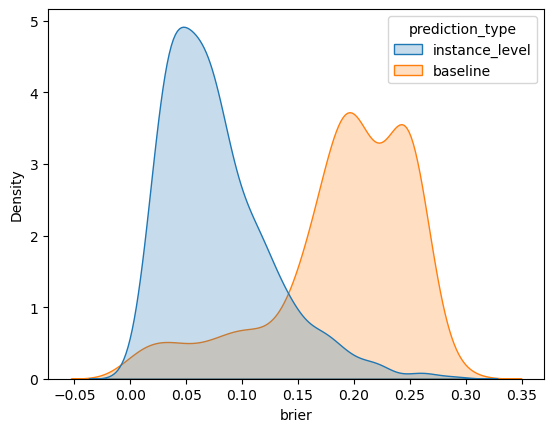

In [87]:
# plot the distribution of the two Brier scores:
sns.kdeplot(res_df, x='brier', hue='prediction_type', shade=True)

/tmp/ipykernel_25271/2330421406.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(res_df_unique["brier_diff"], shade=True)
/home/lorenzo/miniconda3/envs/recog-LLM_capabilities_conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lorenzo/miniconda3/envs/recog-LLM_capabilities_conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='brier_diff', ylabel='Density'>

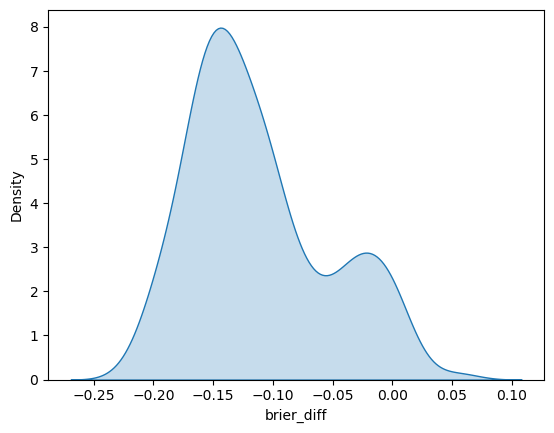

In [77]:
# plot the distribution of the difference in brier score
res_df_unique["brier_diff"] = res_df_unique["brier"] - res_df_unique["brirer_baseline"]
sns.kdeplot(res_df_unique["brier_diff"], shade=True)

In [82]:
print("The instance-level prediction is better than the average performance in the training set in", (res_df_unique["brier_diff"] < 0).sum(), "cases out of", len(res_df_unique), "cases (i.e., ", (res_df_unique["brier_diff"] < 0).sum() / len(res_df_unique) * 100, "%)")

The instance-level prediction is better than the average performance in the training set in 545 cases out of 570 cases (i.e.,  95.6140350877193 %)


For each scenario, show a barplot with the Brier score for the instance-level predictions and the baseline for each model.

/home/lorenzo/miniconda3/envs/recog-LLM_capabilities_conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lorenzo/miniconda3/envs/recog-LLM_capabilities_conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lorenzo/miniconda3/envs/recog-LLM_capabilities_conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lorenzo/miniconda3/envs/recog-LLM_capabilities_conda/lib/python3.11/site-packages/seaborn/_

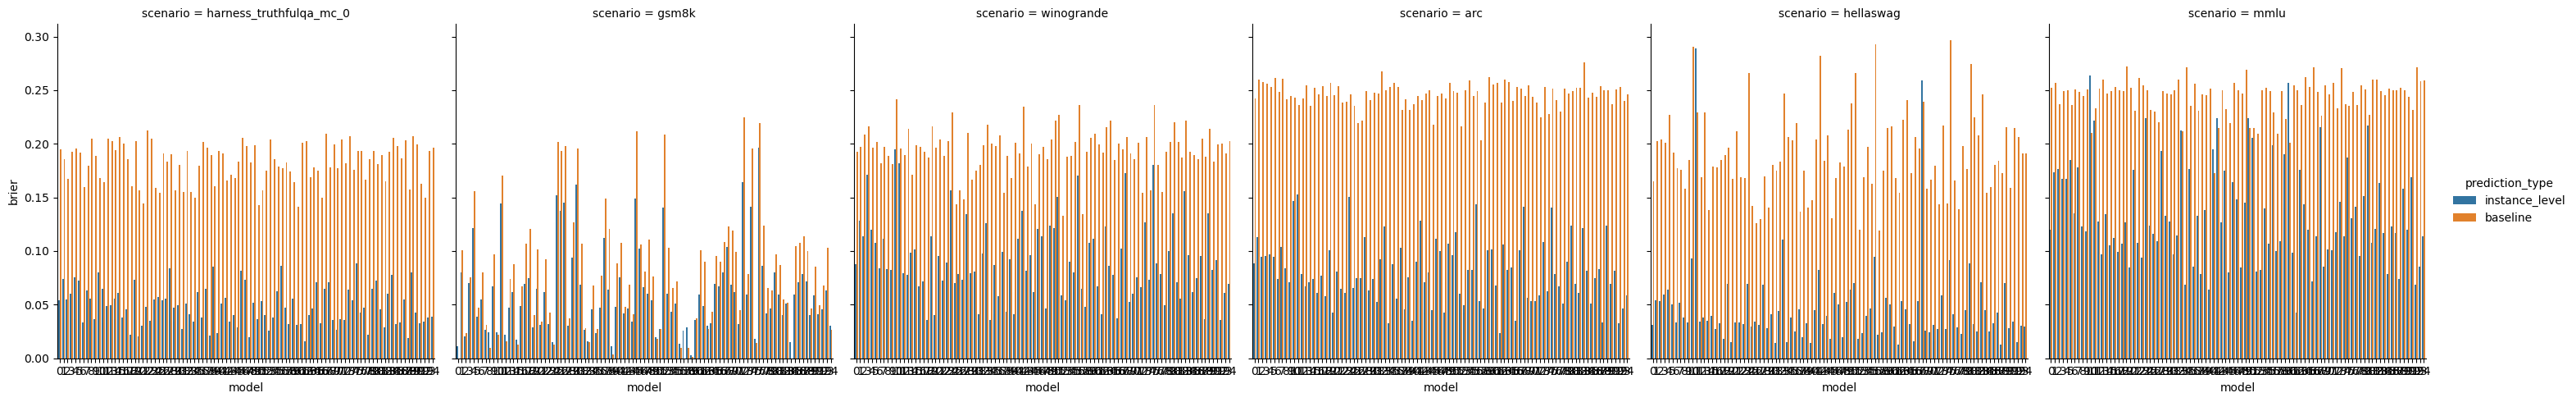

In [83]:
sns.catplot(data=res_df, x='model', y='brier', col="scenario", hue="prediction_type", kind="bar")

#### gp-IRT

This combines the estimate obtained with the anchor points with the estimate obtained with the IRT model.

Loading lambdas

In [15]:
with open('data/lambds.pickle', 'rb') as handle:
    lambds = pickle.load(handle)

Computing estimates and their average errors

In [16]:
gpirt_preds = {}
for scenario in scenarios.keys():
    gpirt_preds[scenario] = lambds[scenario] * preds[scenario] + (1 - lambds[scenario]) * pirt_preds[scenario]
    true = (balance_weights * Y_test)[:, scenarios_position[scenario]].mean(axis=1)  # True performance

    print(f"scenario: {scenario}, avg. error: {np.abs(gpirt_preds[scenario] - true).mean():.3f}")

scenario: harness_truthfulqa_mc_0, avg. error: 0.013
scenario: gsm8k, avg. error: 0.018
scenario: winogrande, avg. error: 0.013
scenario: arc, avg. error: 0.012
scenario: hellaswag, avg. error: 0.014
scenario: mmlu, avg. error: 0.023
